##PINNs for solving PDEs
IN this task, we aim at solving the system of equations with physical informed neural networks. In particular we are interest in the solution of the system during the charging phase of the first cycle. 

consider the non-dimensional set of equations 

approximate the solutions of the system of PDEs with a physical informed neural network(PINNs) 

to this end, you can either use: 
_s
1. a two-outputs network (t,x) -> (T_f, T_s) with tunable parameters Theta 
2. two distinct neural networks (t,x) -> Tf and (t,x) -> T_s with distinct sets of tunable parameters Theta_s and Theta_f


The Python script Pinns.ipynb can be easily modified to address the task. You can follow the steps: 
1. initialize the approximate neural network solutions in the Pinns class 
2. implement the functions add_interior_points, add_temporal_boundary_points and add_spatial_boundary_points 
3. implement the functions apply_initial_conditions
4. implement the function appy_boundary_conditions 
5. implement the function compute_pde+residuals
6. train the model 

once the model is trainedm, preductions of your model on the data stored in TestingData.txt


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)


Bad key "text.kerning_factor" on line 4 in
/Users/chenyilu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import torch.nn as nn
import torch
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
torch.manual_seed(42)


class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param, regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss


def fit(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. below
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p) + model.regularization()
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        if verbose: print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history



In [62]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_, test):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        self.test = test


        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # FF Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution_tf = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=34)
        self.approximate_solution_ts = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=34)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    # ? 
    def initial_condition_tf(self,t):
        T_hot = 4 
        T_0 =1  

        return (T_hot-T_0)/(1+torch.exp(-200*(t-0.25)))+T_0

    # Exact solution for the heat equation ut = u_xx with the IC above

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        T_0 =1
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = np.zeros((input_tb.shape[0],1)).reshape(-1, 1)+T_0

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = self.initial_condition_tf(input_sb[:,0]).reshape(-1,1)
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        #print(output_tb, input_tb.shape)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, torch.tensor(output_tb)), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        tf_pred_tb = self.approximate_solution_tf(input_tb)
        ts_pred_tb = self.approximate_solution_ts(input_tb)
        return tf_pred_tb, ts_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):

        input_sb.requires_grad = True

        tf_pred_sb = self.approximate_solution_tf(input_sb)
        grad_tf_pred_sb = torch.autograd.grad(tf_pred_sb.sum(), input_sb, create_graph=True)[0]
        grad_tf_pred_sb_x=grad_tf_pred_sb[:,1]

        ts_pred_sb = self.approximate_solution_ts(input_sb)
        grad_ts_pred_sb = torch.autograd.grad(ts_pred_sb.sum(), input_sb, create_graph=True)[0]
        grad_ts_pred_sb_x=grad_ts_pred_sb[:,1]
        return tf_pred_sb, grad_tf_pred_sb_x, grad_ts_pred_sb_x

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        U_f = 1 
        alpha_f = 0.05 
        alpha_s = 0.08 
        hf = 5
        hs = 6 

        input_int.requires_grad = True
        tf = self.approximate_solution_tf(input_int)
        ts = self.approximate_solution_ts(input_int)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_tf = torch.autograd.grad(tf.sum(), input_int, create_graph=True)[0]
        grad_tf_t = grad_tf[:, 0]
        grad_tf_x = grad_tf[:, 1]
        grad_tf_xx = torch.autograd.grad(grad_tf_x.sum(), input_int, create_graph=True)[0][:, 1]

        grad_ts = torch.autograd.grad(ts.sum(), input_int, create_graph=True)[0]
        grad_ts_t = grad_ts[:, 0]
        grad_ts_x = grad_ts[:, 1]
        grad_ts_xx = torch.autograd.grad(grad_ts_x.sum(), input_int, create_graph=True)[0][:, 1]


        residual_tf = grad_tf_t + U_f * grad_tf_x - alpha_f * grad_tf_xx + hf*(tf- ts)
        residual_ts = grad_ts_t - alpha_s * grad_ts_xx - hs*(tf-ts)

        
        return residual_tf.reshape(-1, ), residual_ts.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        tf_pred_sb, grad_tf_pred_sb_x, grad_ts_pred_sb_x = self.apply_boundary_conditions(inp_train_sb)
        tf_pred_tb, ts_pred_tb = self.apply_initial_condition(inp_train_tb)
        

        assert (tf_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (tf_pred_tb.shape[1] == u_train_tb.shape[1])
        #assert (ts_pred_sb.shape[1] == ts_train_sb.shape[1])
        assert (ts_pred_tb.shape[1] == u_train_tb.shape[1])

        tf_int, ts_int = self.compute_pde_residual(inp_train_int)

        r_tf_sb_1 = u_train_sb[:len(tf_pred_sb)//2,:] - tf_pred_sb[:len(tf_pred_sb)//2, :] 
        r_tf_sb_2 = 0 - grad_tf_pred_sb_x[len(tf_pred_sb)//2:]
        r_tf_sb = torch.cat((r_tf_sb_1, r_tf_sb_2.reshape(-1,1)),0)
        r_tf_tb = u_train_tb - tf_pred_tb
        # print(r_tf_sb)
        # print(r_tf_tb)
        #print(u_train_tb) 
        #print(tf_pred_tb)

        r_ts_sb = 0 - grad_ts_pred_sb_x
        r_ts_tb = u_train_tb - ts_pred_tb
        # print(r_ts_sb)
        # print(r_ts_tb)

        loss_sb_tf = torch.mean(r_tf_sb ** 2)
        loss_tb_tf = torch.mean(r_tf_tb ** 2)
        loss_int_tf = torch.mean(tf_int ** 2)
        print(loss_sb_tf)
        print(loss_tb_tf) 

        loss_sb_ts = torch.mean(r_ts_sb ** 2)
        loss_tb_ts = torch.mean(r_ts_tb ** 2)
        loss_int_ts = torch.mean(ts_int ** 2)
        print(loss_sb_ts) 
        print(loss_tb_ts)

        loss_int = loss_int_tf + loss_int_ts
        loss_fun = loss_sb_tf + loss_sb_ts + loss_tb_tf + loss_tb_ts
        #print(loss_fun)

        loss = torch.log10(self.lambda_u * loss_fun + loss_int)

        if verbose: print("Total tf loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_int).item(), 4), "| Function Loss: ", round(torch.log10(loss_fun).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer_tf, optimizer_ts, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer_tf.zero_grad()
                    optimizer_ts.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()
                    history.append(loss.item())
                    return loss
                
                
                optimizer_tf.step(closure=closure)
                optimizer_ts.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output_tf = self.approximate_solution_tf(inputs).reshape(-1, )
        output_ts = self.approximate_solution_ts(inputs).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_tf.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_ts.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Tf solution")
        axs[1].set_title("Ts solution")

        plt.show()
    
    def predict(self):
        output = self.test.copy()
        test = torch.from_numpy(self.test.values).float()
        output_tf = self.approximate_solution_tf(test).reshape(-1, )
        output_ts = self.approximate_solution_ts(test).reshape(-1, )
        output['tf'] = output_tf.detach().numpy()
        output['ts'] = output_ts.detach().numpy()
        return output

        

In [63]:
n_int = 256
n_sb = 64
n_tb = 64

import pandas as pd
test = pd.read_csv("TestingData.txt")

pinn = Pinns(n_int, n_sb, n_tb, test)

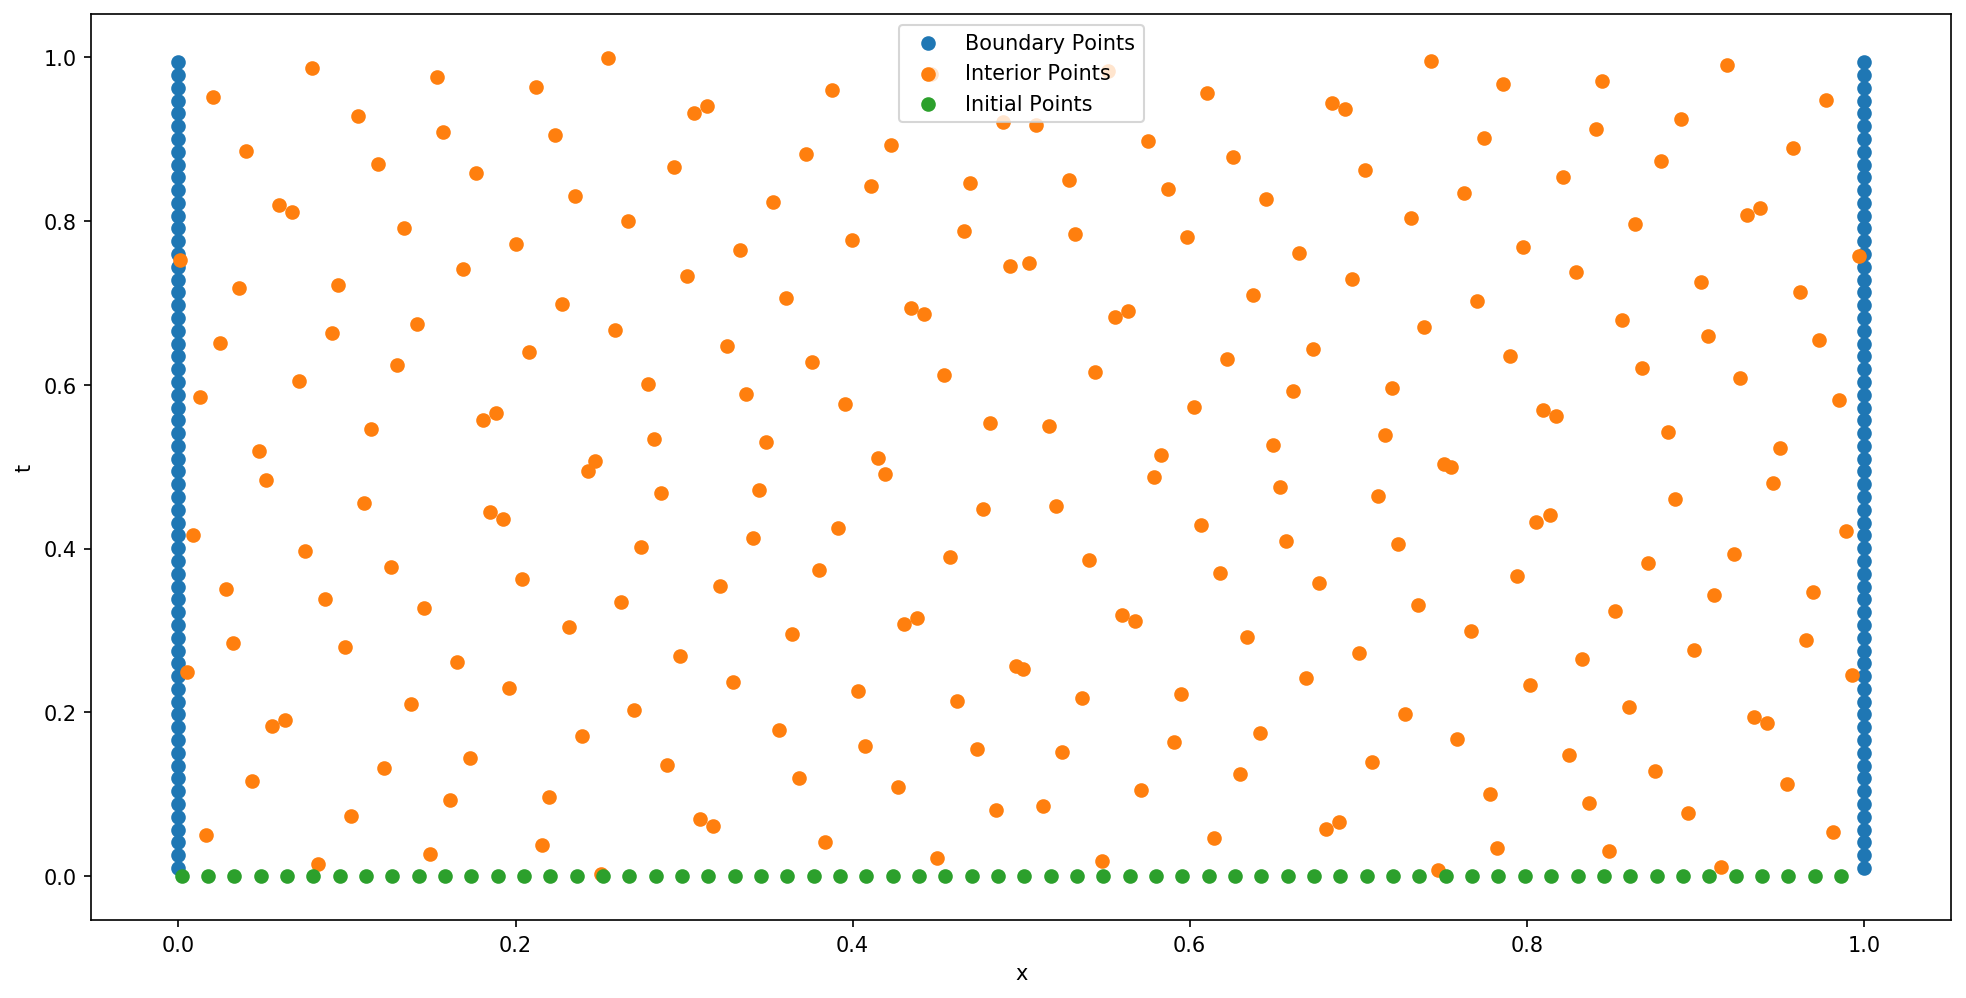

In [64]:
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [65]:
n_epochs = 1
optimizer_LBFGS_tf = optim.LBFGS(pinn.approximate_solution_tf.parameters(),
                              lr=float(0.5),
                              max_iter=4,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

optimizer_LBFGS_ts = optim.LBFGS(pinn.approximate_solution_ts.parameters(),
                              lr=float(0.5),
                              max_iter=4,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

optimizer_ADAM_tf = optim.Adam(pinn.approximate_solution_tf.parameters(),
                            lr=float(0.0005))
optimizer_ADAM_ts = optim.Adam(pinn.approximate_solution_ts.parameters(),
                            lr=float(0.0005))

################################  0  ################################
tensor([[ 1.0000],
        [ 2.4011],
        [ 2.3047],
        [ 1.3111],
        [ 2.5384],
        [ 2.2957],
        [ 2.3346],
        [ 0.3008],
        [ 0.0251],
        [ 2.3163],
        [ 2.2966],
        [ 2.4576],
        [ 2.6525],
        [ 2.2982],
        [ 2.3617],
        [ 0.6330],
        [ 0.4608],
        [ 2.3468],
        [ 2.2965],
        [ 2.5906],
        [ 2.4268],
        [ 2.2981],
        [ 2.3098],
        [-0.0836],
        [ 0.1552],
        [ 2.3245],
        [ 2.2958],
        [ 2.4945],
        [ 2.7197],
        [ 2.3009],
        [ 2.3796],
        [ 0.8141],
        [ 0.7227],
        [ 2.3702],
        [ 2.2994],
        [ 2.6873],
        [ 2.4752],
        [ 2.2961],
        [ 2.3202],
        [ 0.0882],
        [-0.0147],
        [ 2.3071],
        [ 2.2991],
        [ 2.4134],
        [ 2.5634],
        [ 2.2960],
        [ 2.3404],
        [ 0.3791],
        [ 0.5456],

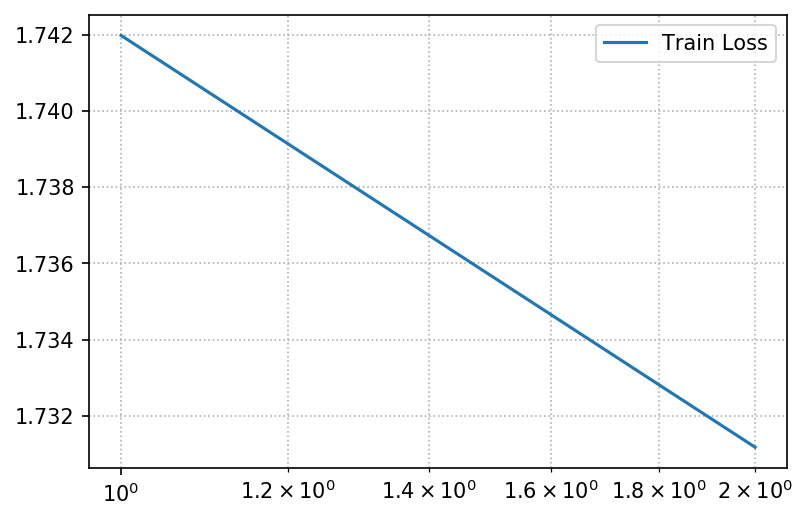

In [66]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer_tf=optimizer_ADAM_tf,
                optimizer_ts=optimizer_ADAM_ts,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

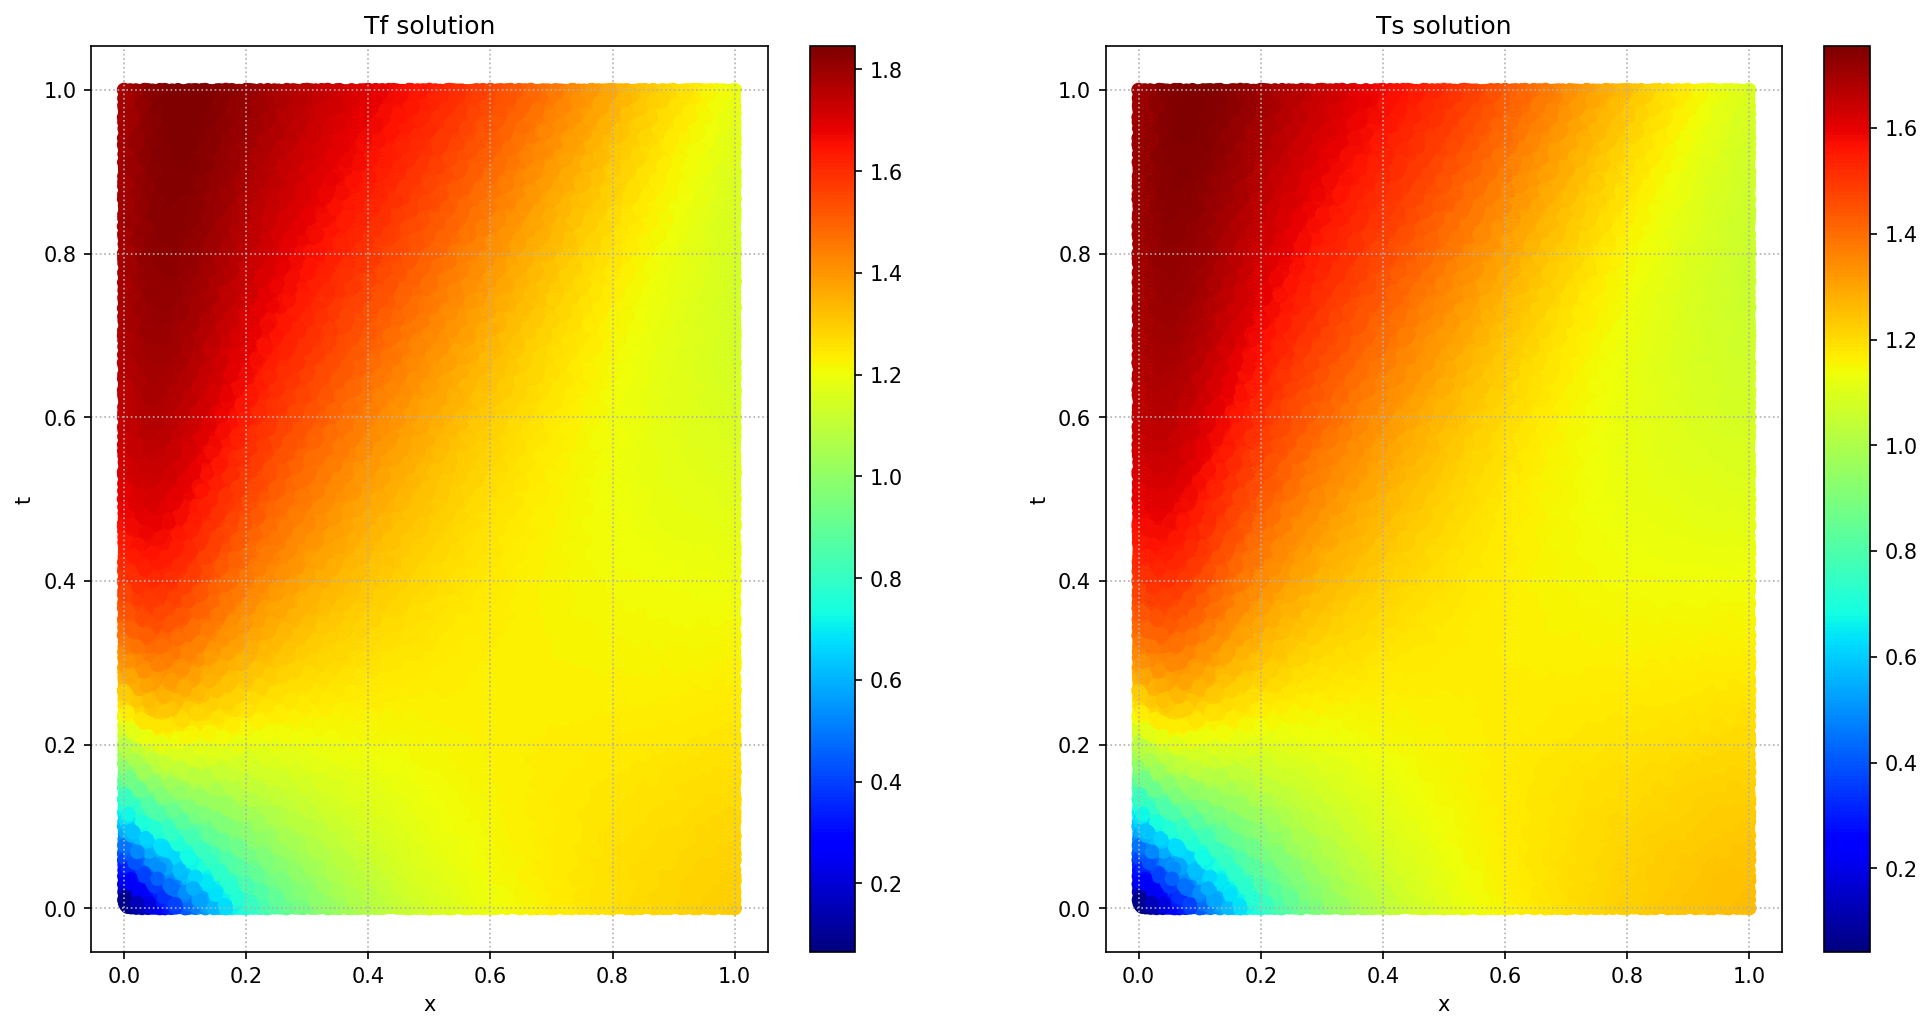

In [41]:
pinn.plotting()

In [9]:
output = pinn.predict()